# Bank Central Asia Stock Forecasting using Sentiment Analysis 

BCA (Bank Central Asia) is one of the largest banks in Indonesia, and as with many publicly traded companies, its stock price is subject to a wide range of market forces, including news articles, social media mentions, and other factors that can affect investor sentiment. Sentiment analysis is a powerful tool for analyzing such market data, allowing investors and analysts to better understand the market sentiment around a particular stock. In this analysis, we will examine the use of sentiment analysis to forecast the stock price of BCA and explore how it can provide valuable insights into the underlying market sentiment and potential future trends.

<i><b>"This analysis is performed to compare the use of sentiment analysis feature in LSTM forecasting models"</b></i>
<br><br>
<i>Note : (10 April 2023) This notebook is a part of assignment of Master of Information Technology - Universitas Indonesia (2021SB)</i>

### Libraries

In [1]:
!pip install stemming
!pip install yfinance
!pip install yahoofinancials
!pip install -U deep-translator

import re
import time
import math
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from textblob import TextBlob 
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import layers
from yahoofinancials import YahooFinancials
from deep_translator import GoogleTranslator
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler 

sns.set_style("darkgrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28645 sha256=ff1b3aaaa90f59df2d726542b917094c96007ee6f43e8564fbe56bf37d4c58bf
  Stored in directory: /root/.cache/pip/wheels/a7/3d/f5/5e521d8cb9587d7601ae7016d612f723eee97022168983dd79
Successfully built yahoofinancials


### Functions

In [2]:
def remove_links(text):
    cleaned_text = re.sub(r'http\S+', '', text)
    return cleaned_text

def clean_hashtags(tweet):
    cleaned_tweet = re.sub(r'#(\w+)', '', tweet)
    return cleaned_tweet

def remove_usernames(text):
    cleaned_text = re.sub(r'@\w+', '', text)
    return cleaned_text

def remove_emoticons(text):
    pattern = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                         u"\U0001F680-\U0001F6FF"  # transport & map symbols
                         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+", flags=re.UNICODE)
    return pattern.sub(r'', text)

def windowing(data,window):
    data_w = []
    for i in range(window, len(data)):
        data_w.append(data[i-window:i])
    
    data_w = np.reshape(data_w,(
    np.shape(data_w)[0],
    np.shape(data_w)[2],
    np.shape(data_w)[1]))
    
    data_w = np.array(data_w)
    return data_w

## 1. Get BBCA Stock Prices from Yahoo Finance

In [3]:
yahoo_financials = YahooFinancials('BBCA.JK')
data = yahoo_financials.get_historical_price_data(start_date='2021-11-29', 
                                                  end_date='2022-11-29', 
                                                  time_interval='daily')
stock = pd.DataFrame(data['BBCA.JK']['prices'])
stock = stock.drop('date', axis=1).set_index('formatted_date')
stock["date"] = stock.index
stock["date"] = stock['date'].astype('datetime64[ns]')
stock = stock.reset_index(drop = True)

## 2. Generate Relevant Stock Features 

In [4]:
stock["close_yesterday"] = stock.close.shift(1)
stock["open_yesterday"] = stock.open.shift(1)
stock["volume_yesterday"] = stock.volume.shift(1)
stock["low_yesterday"] = stock.low.shift(1)
stock["price_diff_yesterday"] = stock["close"] - stock["close_yesterday"]
stock["price_limit_yesterday"] = (stock["close"] - stock["close_yesterday"])/stock["close_yesterday"]
stock["volume_diff_yesterday"] = stock["volume"] - stock["volume_yesterday"]
stock["volume_limit_yesterday"] = (stock["volume"] - stock["volume_yesterday"])/stock["volume_yesterday"]
stock["amplitude_yesterday"] = (stock["high"]-stock["low_yesterday"])/stock["close_yesterday"]
stock["difference_yesterday"] = (stock["close"]-stock["open"])/stock["close_yesterday"]
technical_columns = ["date","open","close","high","low","volume","price_diff_yesterday","price_limit_yesterday",
                     "volume_diff_yesterday", "volume_limit_yesterday","amplitude_yesterday", "difference_yesterday"]
stock = stock[technical_columns]

## 3. Generate Price Target

In [5]:
stock["target"] = stock.close.shift(-1)
stock = stock.iloc[1:].reset_index(drop=True)
stock.head()

,date,open,close,high,low,volume,price_diff_yesterday,price_limit_yesterday,volume_diff_yesterday,volume_limit_yesterday,amplitude_yesterday,difference_yesterday,target
0,2021-11-30,7325.0,7275.0,7425.0,7275.0,144923700,-125.0,-0.016892,57015800.0,0.648586,0.033784,-0.006757,7300.0
1,2021-12-01,7275.0,7300.0,7450.0,7275.0,76538100,25.0,0.003436,-68385600.0,-0.471873,0.024055,0.003436,7500.0
2,2021-12-02,7375.0,7500.0,7500.0,7300.0,66831000,200.0,0.027397,-9707100.0,-0.126827,0.030822,0.017123,7375.0
3,2021-12-03,7525.0,7375.0,7525.0,7350.0,63283700,-125.0,-0.016667,-3547300.0,-0.053079,0.030000,-0.020000,7350.0
4,2021-12-06,7450.0,7350.0,7475.0,7350.0,56944100,-25.0,-0.003390,-6339600.0,-0.100177,0.016949,-0.013559,7350.0


## 4. Exploratory Data Analysis

In [6]:
print("Data Shape :",np.shape(stock))
stock.info()

Data Shape : (245, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    245 non-null    datetime64[ns]
 1   open                    245 non-null    float64       
 2   close                   245 non-null    float64       
 3   high                    245 non-null    float64       
 4   low                     245 non-null    float64       
 5   volume                  245 non-null    int64         
 6   price_diff_yesterday    245 non-null    float64       
 7   price_limit_yesterday   245 non-null    float64       
 8   volume_diff_yesterday   245 non-null    float64       
 9   volume_limit_yesterday  245 non-null    float64       
 10  amplitude_yesterday     245 non-null    float64       
 11  difference_yesterday    245 non-null    float64       
 12  target                  244

There is no NULL value in the dataset

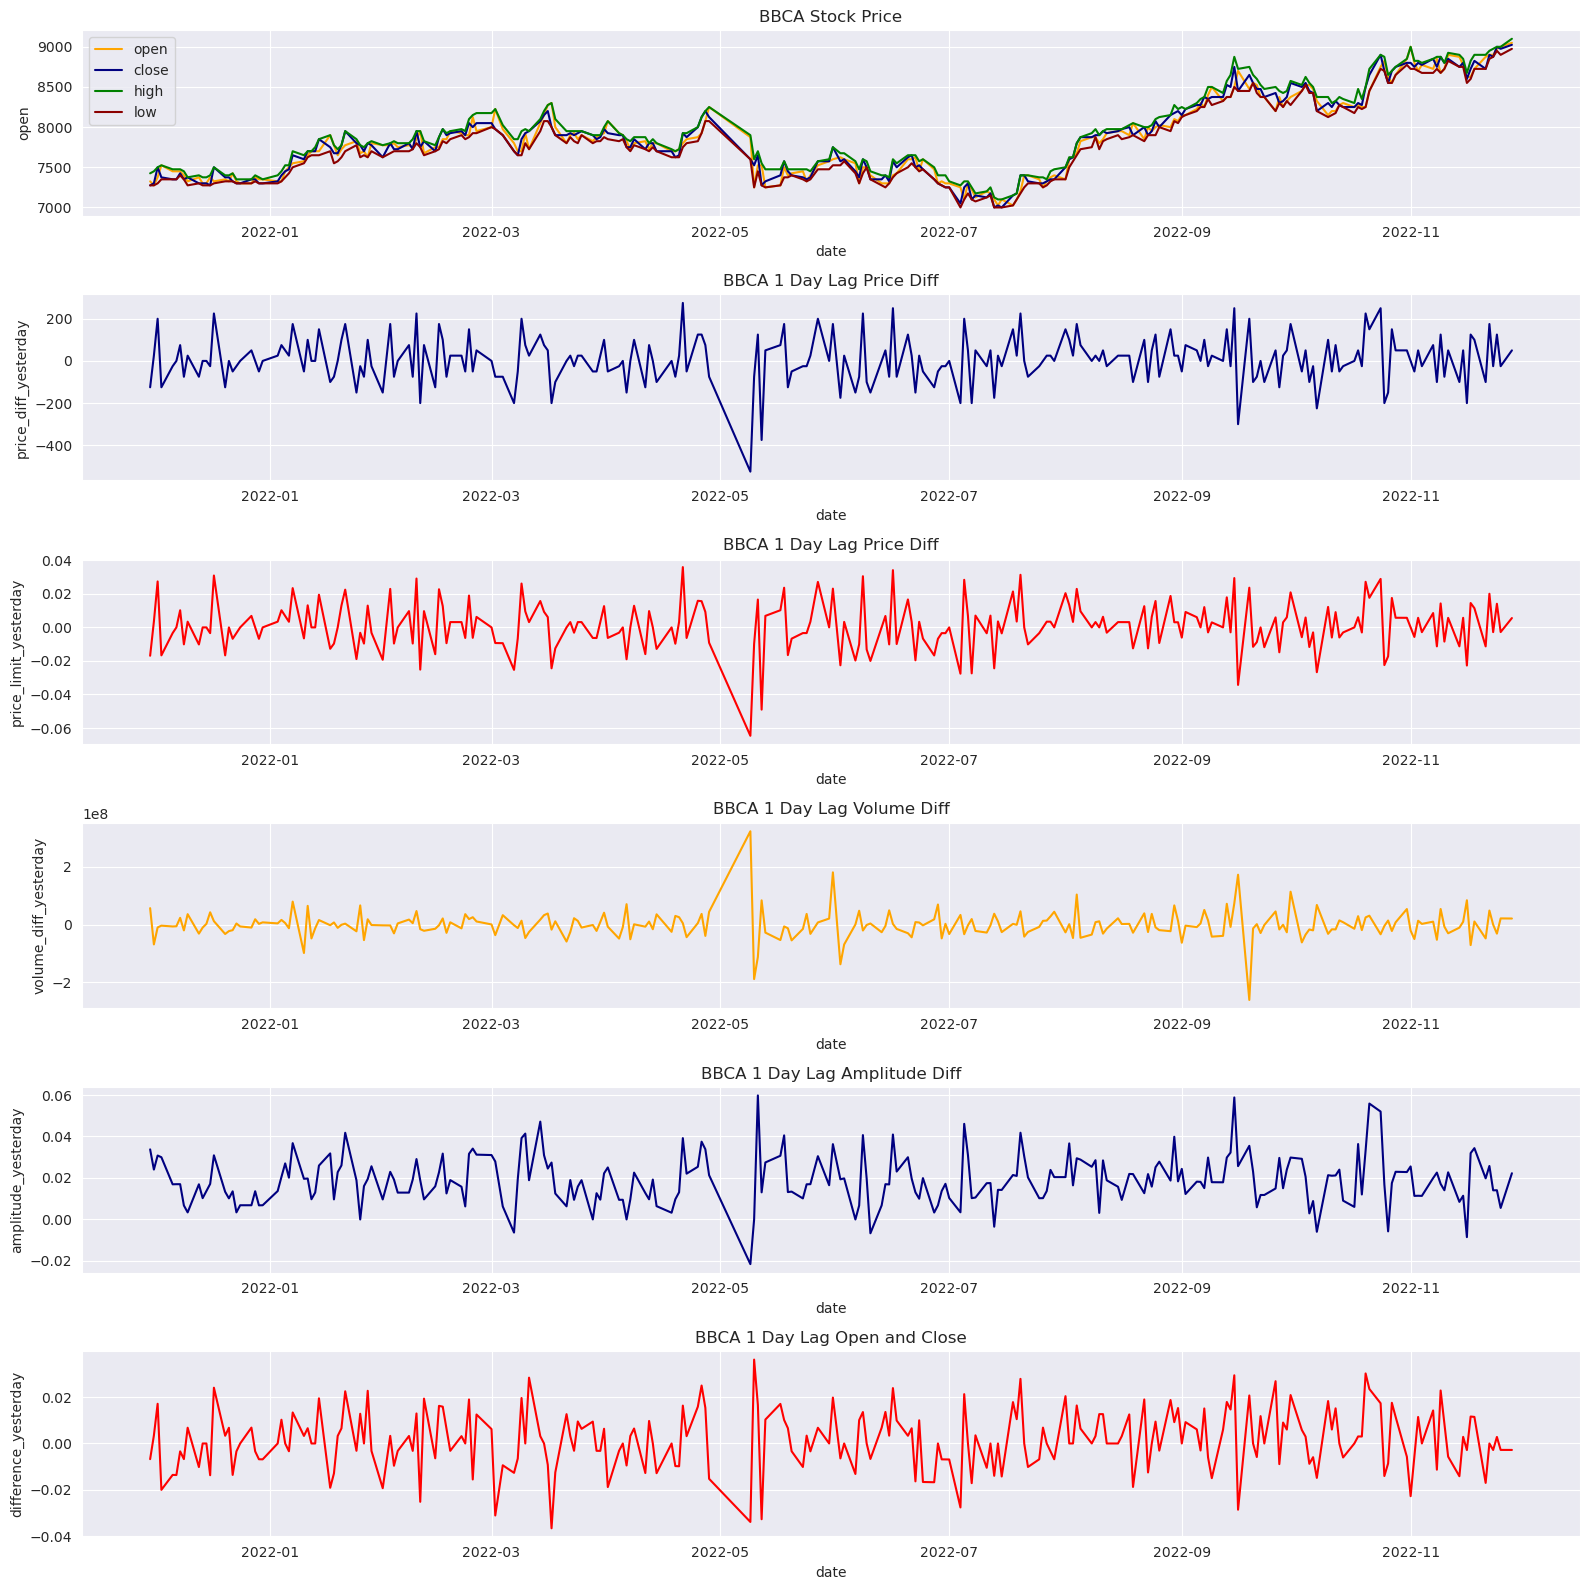

In [7]:
fig,ax = plt.subplots(6,1,figsize=(16,16))
sns.lineplot(data = stock, x="date",y="open",ax=ax[0],label = "open",color = "orange")
sns.lineplot(data = stock, x="date",y="close",ax=ax[0], label = "close", color = "navy")
sns.lineplot(data = stock, x="date",y="high",ax=ax[0], label = "high", color = "green")
sns.lineplot(data = stock, x="date",y="low",ax=ax[0], label = "low", color = "darkred")
ax[0].set_title("BBCA Stock Price")

sns.lineplot(data = stock, x="date", y="price_diff_yesterday",ax=ax[1], color = "navy")
ax[1].set_title("BBCA 1 Day Lag Price Diff")

sns.lineplot(data = stock, x="date", y="price_limit_yesterday",ax=ax[2], color = "red")
ax[2].set_title("BBCA 1 Day Lag Price Diff")

sns.lineplot(data = stock, x="date", y="volume_diff_yesterday",ax=ax[3], color = "orange")
ax[3].set_title("BBCA 1 Day Lag Volume Diff")

sns.lineplot(data = stock, x="date", y="amplitude_yesterday",ax=ax[4], color = "navy")
ax[4].set_title("BBCA 1 Day Lag Amplitude Diff")

sns.lineplot(data = stock, x="date", y="difference_yesterday",ax=ax[5], color = "red")
ax[5].set_title("BBCA 1 Day Lag Open and Close")

fig.tight_layout()
plt.show()

## 5. Get Tweet Data 

In [8]:
bca_sentiment = pd.read_excel("/kaggle/input/bank-central-asia-tweet/saham_bca.xlsx")[["id","permalink","username","text","date"]]
bca_sentiment.head()

,id,permalink,username,text,date
0,1.597243e+18,https://twitter.com/KisenKumar24/status/159724...,KisenKumar24,Kamu trader atau investor? Ini Bedanya\n\nhttp...,2022-11-28
1,1.597141e+18,https://twitter.com/RaytiaPurnama/status/15971...,RaytiaPurnama,Hujan gini enak ny berselimut saham BCA https:...,2022-11-28
2,1.597096e+18,https://twitter.com/wdrsyf/status/159709637887...,wdrsyf,Saham BCA lagi +100 nih,2022-11-28
3,1.597089e+18,https://twitter.com/Saham_fess/status/15970889...,Saham_fess,shm! udah mulai diatas 9000 nih bca nya,2022-11-28
4,1.597027e+18,https://twitter.com/jihanhunteur/status/159702...,jihanhunteur,"Hai Hai, aku baru beli saham pertamaku di Ajai...",2022-11-28


## 6. Processing Tweet Data  

### 6.1 Initial Punctuation and Character Cleansing

In [9]:
bca_sentiment["text_cleansed"] = bca_sentiment.text.apply(lambda x: re.sub(r'\r?\n', '', x))
bca_sentiment["text_cleansed"] = bca_sentiment.text.apply(lambda x: remove_emoticons(remove_usernames(remove_links(clean_hashtags(x)))).rstrip())
bca_sentiment.head()

,id,permalink,username,text,date,text_cleansed
0,1.597243e+18,https://twitter.com/KisenKumar24/status/159724...,KisenKumar24,Kamu trader atau investor? Ini Bedanya\n\nhttp...,2022-11-28,Kamu trader atau investor? Ini Bedanya
1,1.597141e+18,https://twitter.com/RaytiaPurnama/status/15971...,RaytiaPurnama,Hujan gini enak ny berselimut saham BCA https:...,2022-11-28,Hujan gini enak ny berselimut saham BCA
2,1.597096e+18,https://twitter.com/wdrsyf/status/159709637887...,wdrsyf,Saham BCA lagi +100 nih,2022-11-28,Saham BCA lagi +100 nih
3,1.597089e+18,https://twitter.com/Saham_fess/status/15970889...,Saham_fess,shm! udah mulai diatas 9000 nih bca nya,2022-11-28,shm! udah mulai diatas 9000 nih bca nya
4,1.597027e+18,https://twitter.com/jihanhunteur/status/159702...,jihanhunteur,"Hai Hai, aku baru beli saham pertamaku di Ajai...",2022-11-28,"Hai Hai, aku baru beli saham pertamaku di Ajai..."


### 6.2 Translate to English

In [10]:
bca_sentiment["text_eng"] = None
translation_eng = []
c = 0
for tx in bca_sentiment.text_cleansed:
    try:
        translate_text = GoogleTranslator(source='id', target='en').translate(tx) 
        translation_eng.append(translate_text)
    except:
        c = c + 1
        translation_eng.append("Google Translate Error")

bca_sentiment["text_eng"] = translation_eng
print("error num : ",c)
bca_sentiment.head()

error num :  0


,id,permalink,username,text,date,text_cleansed,text_eng
0,1.597243e+18,https://twitter.com/KisenKumar24/status/159724...,KisenKumar24,Kamu trader atau investor? Ini Bedanya\n\nhttp...,2022-11-28,Kamu trader atau investor? Ini Bedanya,Are you a trader or investor? This is the diff...
1,1.597141e+18,https://twitter.com/RaytiaPurnama/status/15971...,RaytiaPurnama,Hujan gini enak ny berselimut saham BCA https:...,2022-11-28,Hujan gini enak ny berselimut saham BCA,It's nice to be covered in BCA shares in this ...
2,1.597096e+18,https://twitter.com/wdrsyf/status/159709637887...,wdrsyf,Saham BCA lagi +100 nih,2022-11-28,Saham BCA lagi +100 nih,BCA shares are +100 again
3,1.597089e+18,https://twitter.com/Saham_fess/status/15970889...,Saham_fess,shm! udah mulai diatas 9000 nih bca nya,2022-11-28,shm! udah mulai diatas 9000 nih bca nya,"shm! It's starting above 9000, read it"
4,1.597027e+18,https://twitter.com/jihanhunteur/status/159702...,jihanhunteur,"Hai Hai, aku baru beli saham pertamaku di Ajai...",2022-11-28,"Hai Hai, aku baru beli saham pertamaku di Ajai...","Hi Hi, I just bought my first shares in Ajaib...."


### 6.3 Sentiment Scoring using TextBlob

In [11]:
score_list = []
for te in bca_sentiment["text_eng"]:
    blob = TextBlob(te)
    sentiment_score = blob.sentiment.polarity
    score_list.append(sentiment_score)
    
bca_sentiment["sentiment_score"] = score_list
bca_sentiment.head()

,id,permalink,username,text,date,text_cleansed,text_eng,sentiment_score
0,1.597243e+18,https://twitter.com/KisenKumar24/status/159724...,KisenKumar24,Kamu trader atau investor? Ini Bedanya\n\nhttp...,2022-11-28,Kamu trader atau investor? Ini Bedanya,Are you a trader or investor? This is the diff...,0.00
1,1.597141e+18,https://twitter.com/RaytiaPurnama/status/15971...,RaytiaPurnama,Hujan gini enak ny berselimut saham BCA https:...,2022-11-28,Hujan gini enak ny berselimut saham BCA,It's nice to be covered in BCA shares in this ...,0.60
2,1.597096e+18,https://twitter.com/wdrsyf/status/159709637887...,wdrsyf,Saham BCA lagi +100 nih,2022-11-28,Saham BCA lagi +100 nih,BCA shares are +100 again,0.00
3,1.597089e+18,https://twitter.com/Saham_fess/status/15970889...,Saham_fess,shm! udah mulai diatas 9000 nih bca nya,2022-11-28,shm! udah mulai diatas 9000 nih bca nya,"shm! It's starting above 9000, read it",0.00
4,1.597027e+18,https://twitter.com/jihanhunteur/status/159702...,jihanhunteur,"Hai Hai, aku baru beli saham pertamaku di Ajai...",2022-11-28,"Hai Hai, aku baru beli saham pertamaku di Ajai...","Hi Hi, I just bought my first shares in Ajaib....",0.45


### 6.4 Daily Sentiment Average 

Text(0.5, 1.0, 'Sentiment Score Distribution')

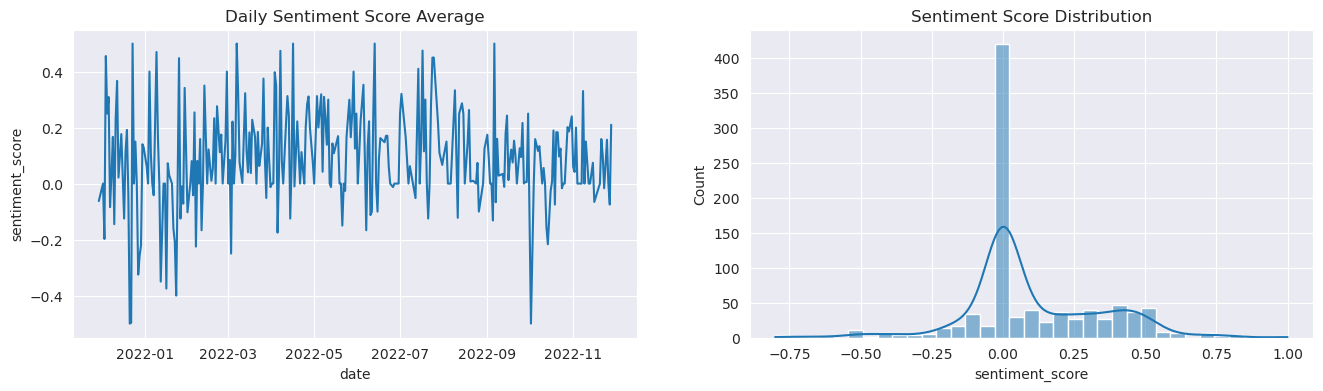

In [12]:
daily_sentiment_avg = bca_sentiment.groupby("date").mean()[["sentiment_score"]].reset_index()
fig,ax = plt.subplots(1,2,figsize=(16,4))
sns.lineplot(data = daily_sentiment_avg, x="date", y="sentiment_score", ax = ax[0])
sns.histplot(bca_sentiment.sentiment_score, kde=True,ax=ax[1])
ax[0].set_title("Daily Sentiment Score Average")
ax[1].set_title("Sentiment Score Distribution")

## 7. Modelling 

### 7.1 Dataset Preparation

In [13]:
dataset = pd.merge(stock,daily_sentiment_avg,left_on="date",right_on="date",how="inner")
# Repositioning Target Columns
target = dataset.target
dataset = dataset.drop("target",axis=1)
dataset["target"] = target
dataset.head()

,date,open,close,high,low,volume,price_diff_yesterday,price_limit_yesterday,volume_diff_yesterday,volume_limit_yesterday,amplitude_yesterday,difference_yesterday,sentiment_score,target
0,2021-12-02,7375.0,7500.0,7500.0,7300.0,66831000,200.0,0.027397,-9707100.0,-0.126827,0.030822,0.017123,0.000000,7375.0
1,2021-12-03,7525.0,7375.0,7525.0,7350.0,63283700,-125.0,-0.016667,-3547300.0,-0.053079,0.030000,-0.020000,-0.197840,7350.0
2,2021-12-06,7450.0,7350.0,7475.0,7350.0,56944100,-25.0,-0.003390,-6339600.0,-0.100177,0.016949,-0.013559,0.308971,7350.0
3,2021-12-07,7450.0,7350.0,7475.0,7350.0,51258200,0.0,0.000000,-5685900.0,-0.099851,0.017007,-0.013605,-0.084000,7425.0
4,2021-12-08,7450.0,7425.0,7475.0,7400.0,74775000,75.0,0.010204,23516800.0,0.458791,0.017007,-0.003401,0.031250,7350.0


### 7.2 Dataset Normalization 

In [14]:
scaler1 = StandardScaler()
scaler1.fit(dataset.drop(["date","sentiment_score"],axis=1))
scaled_dataset_1 = scaler1.transform(dataset.drop(["date","sentiment_score"],axis=1))

scaler2 = StandardScaler()
scaler2.fit(dataset.drop(["date"],axis=1))
scaled_dataset_2 = scaler2.transform(dataset.drop(["date"],axis=1))

### 7.3 Train Test Split 

In [15]:
train_size1 = int(len(scaled_dataset_1) * 0.8)
train_data1, test_data1 = scaled_dataset_1[:train_size1], scaled_dataset_1[train_size1:]

train_size2 = int(len(scaled_dataset_2) * 0.8)
train_data2, test_data2 = scaled_dataset_2[:train_size2], scaled_dataset_2[train_size2:]

print("Train 1 Shape : ",np.shape(train_data1))
print("Train 2 Shape : ",np.shape(train_data2))
print("Test 1 Shape : ",np.shape(test_data1))
print("Test 2 Shape : ",np.shape(test_data2))

x_train_1 = train_data1[:,:-1]
y_train_1 = train_data1[:,-1]
x_test_1 = test_data1[:,:-1]
y_test_1 = test_data1[:,-1]
x_train_2 = train_data2[:,:-1]
y_train_2 = train_data2[:,-1]
x_test_2 = test_data2[:,:-1]
y_test_2 = test_data2[:,-1]

print("X Train 1 Shape : ",np.shape(x_train_1))
print("Y Train 1 Shape : ",np.shape(y_train_1))
print("X Test 1 Shape : ",np.shape(x_test_1))
print("Y Test 1 Shape : ",np.shape(y_test_1))

print("X Train 2 Shape : ",np.shape(x_train_2))
print("Y Train 2 Shape : ",np.shape(y_train_2))
print("X Test 2 Shape : ",np.shape(x_test_2))
print("Y Test 2 Shape : ",np.shape(y_test_2))

Train 1 Shape :  (171, 12)
Train 2 Shape :  (171, 13)
Test 1 Shape :  (43, 12)
Test 2 Shape :  (43, 13)
X Train 1 Shape :  (171, 11)
Y Train 1 Shape :  (171,)
X Test 1 Shape :  (43, 11)
Y Test 1 Shape :  (43,)
X Train 2 Shape :  (171, 12)
Y Train 2 Shape :  (171,)
X Test 2 Shape :  (43, 12)
Y Test 2 Shape :  (43,)


### 7.4 Windowing 

In [16]:
x_train_w1 = windowing(x_train_1,7)
x_test_w1 = windowing(x_test_1,7)
x_train_w2 = windowing(x_train_2,7)
x_test_w2 = windowing(x_test_2,7)
y_train_w1 = y_train_1[7:]
y_train_w2 = y_train_2[7:]
y_test_w1 = y_test_1[7:]
y_test_w2 = y_test_2[7:]

print("Dataset 1 Windowing SHape: ")
print("X Train : ",np.shape(x_train_w1))
print("Y Train : ",np.shape(y_train_w1))
print("X Test :", np.shape(x_test_w1))
print("Y Test :", np.shape(y_test_w1))


print("Dataset 2 Windowing SHape: ")
print("X Train : ",np.shape(x_train_w2))
print("Y Train : ",np.shape(y_train_w2))
print("X Test :", np.shape(x_test_w2))
print("Y Test :", np.shape(y_test_w2))


Dataset 1 Windowing SHape: 
X Train :  (164, 11, 7)
Y Train :  (164,)
X Test : (36, 11, 7)
Y Test : (36,)
Dataset 2 Windowing SHape: 
X Train :  (164, 12, 7)
Y Train :  (164,)
X Test : (36, 12, 7)
Y Test : (36,)


In [17]:
y_train_w1r = np.reshape(y_train_w1, (len(y_train_w1),1))

### 7.2 LSTM only with stocks data

In [18]:
timesteps = x_train_w1.shape[1]
input_dim = x_train_w1.shape[2]
output_dim = 1

# Define the model architecture
model = Sequential()
model.add(LSTM(units=11, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=11))
model.add(Dense(units=output_dim, activation='softmax'))

model.summary()

# Compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_w1, y_train_w1r, batch_size= 1, epochs=100, callbacks=[callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 11)            836       
                                                                 
 dropout (Dropout)           (None, 11, 11)            0         
                                                                 
 lstm_1 (LSTM)               (None, 11)                1012      
                                                                 
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
164/164 [==============================] - 4s 6ms/step - loss: 2.2884
Epoch 2/100
164/164 [==============================] - 1s 6ms/step - loss: 2.2884
Epoch 3/100
164/164 [=

In [19]:
# predictions = model.predict(x_test_w1)
# pred_df = 

### 7.3 LSTM with Stcks and Sentiment Data 

# Code Archive

In [20]:
# import nltk
# from nltk.corpus import wordnet
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer, WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

### Tokenizing 

In [21]:
# token_list = []
# for te in bca_sentiment["text_eng"]:
#     tokens = word_tokenize(te)
#     token_list.append(tokens)

# bca_sentiment["tokenized"] = token_list
# bca_sentiment.head()

### POS Tagging 

In [22]:
# pt_list = []
# for tokens in bca_sentiment.tokenized:
#     pos_tags = nltk.pos_tag(tokens)
#     pt_list.append(pos_tags)
# bca_sentiment["postag"] = pt_list
# bca_sentiment.head()

### Stopword Removal

In [23]:
# # Load the stopwords
# sr_list = []
# stop_words = set(stopwords.words('english'))
# for tokens in bca_sentiment.postag:
#     sr_list_temp = []
#     for word in tokens:
#         if word[0].lower() not in stop_words:
#             sr_list_temp.append(word)
#     sr_list.append(sr_list_temp)

# bca_sentiment["stopremov"] = sr_list
# bca_sentiment.head()

### Lemmatization 

In [24]:
# # FIX NLTK WORDNET ERROR - RUN ONLY IF WORDNET UNZIP ERROR 
# import os

# # Create the directory if it does not already exist
# if not os.path.exists("my_nltk_data"):
#     os.mkdir("my_nltk_data")

# # Add the directory to the list of NLTK data directories
# nltk.data.path.append(os.path.abspath("my_nltk_data"))

# # Download the WordNet corpus to the specified directory
# nltk.download("wordnet", download_dir="my_nltk_data")

# !unzip -o my_nltk_data/corpora/wordnet.zip -d my_nltk_data/corpora/


In [25]:
# def get_wordnet_pos(tag):
#     if tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN # default to noun if tag is not recognized
    
# lemmatizer = WordNetLemmatizer()
# lemmatized = []
# for li in bca_sentiment.stopremov:
#         lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in li] # add pos tag for verbs
#         full_text = ' '.join(lemmatized_words)
#         lemmatized.append(full_text)
# bca_sentiment["lemmatized"] = lemmatized
# bca_sentiment.head()